In [19]:
import os
import random
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
cm = 1/2.54

# force GPU device
os.environ["CUDA_VISIBLE_DEVICES"]='1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.src.layers import SimpleRNN, LSTM, Dense, Dropout, Bidirectional
from keras import Sequential, Input
from keras.optimizers import Adam
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow.keras import Input

In [71]:
data_directory = '/home/jrosendahl/datasets/cadets/sequences_export_benign_filetypes/'
max_sequence_length = 100

data = []

labels = None
labels_cardinality = set()

count_files_read = 0
count_sequences_split = 0
count_splits = 0

distinct_event_types = {}
distinct_users = {}
distinct_filetypes = {}

def parse_line(line):
    event, user, filetype1, filetype2 = line.strip().split(',')
    # vectorize
    event = distinct_event_types.setdefault(event, len(distinct_event_types))
    user = distinct_users.setdefault(user, len(distinct_users))
    filetype1 = distinct_filetypes.setdefault(filetype1, len(distinct_filetypes))
    filetype2 = distinct_filetypes.setdefault(filetype2, len(distinct_filetypes))
    return event, user, filetype1, filetype2

for file_name in os.listdir(data_directory):
    count_files_read += 1
    if count_files_read % 50000 == 0:
        print(f'Loaded {count_files_read} sequences')
    with open(data_directory + file_name, 'r') as f:
        if file_name.count('_') == 2:
            label, _, _ = file_name.split('_')
        elif file_name.count('_') == 3:
            # pwd_mkdb
            label, tmp, _, _ = file_name.split('_')
            label += '_' + tmp
        else:
            print(f'Unknown file name format: {file_name}')
        labels_cardinality.add(label)

        lines = f.readlines()
        # if sequence is longer than max_sequence_length, split into multiple sequences
        if len(lines) > max_sequence_length:
            count_sequences_split += 1
            for i in range(0, len(lines), max_sequence_length):
                count_splits += 1
                datapoints = []
                for line in lines[i:i+max_sequence_length]:
                    event, _, _, _ = parse_line(line)
                    datapoints.append((event,))
                data.append((label, datapoints))
        else:
            datapoints = []
            for line in lines:
                event, _, _, _ = parse_line(line)
                datapoints.append((event,))
            data.append((label, datapoints))


print(f'Loaded {count_files_read} sequences (files)')
print(f'Split {count_sequences_split} sequences into {count_splits} datapoints')
print(f'Loaded {len(data)} datapoints')

labels = [ x[0] for x in data ]
data = [ x[1] for x in data ]

labels_cardinality = len(labels_cardinality)

# get info about the classes
print(f'Found {labels_cardinality} classes')
print(f'Classes: {np.unique(labels)}')
print(f'len(data): {len(data)}, len(labels): {len(labels)}')

# removes classes with less than unusable_threshold samples
samples_before = len(data)

unusable_threshold = 10

# identify unusable classes
unusable_classes = []
for label, count in Counter(labels).items():
    if count < unusable_threshold:
        unusable_classes.append(label)

print(f'Found {len(unusable_classes)} unusable classes with less than {unusable_threshold} samples')
print(f'Unusable classes: {unusable_classes}')

# remove unusable classes from labels/data
data = [ (label, sequence) for label, sequence in zip(labels, data) if label not in unusable_classes ]
labels = [ label for label, _ in data ]
data = [ sequence for _, sequence in data ]

samples_after = len(data)
print(f'Removed {samples_before - samples_after} samples with unusable classes')
print(f'Left with {samples_after} samples, unusable classes made up {(100 * (samples_before - samples_after) / samples_before):.2f}% of the data')


print(f'len(data): {len(data)}, len(labels): {len(labels)}')

# update labels_cardinality
labels_cardinality = len(np.unique(labels))
print(f'Updated labels_cardinality to {labels_cardinality}')

# vectorize labels
label_mapping = { label: i for i, label in enumerate(np.unique(labels)) }
label_mapping_reverse = { i: label for i, label in enumerate(np.unique(labels)) }

labels = [ label_mapping[label] for label in labels ]

event_type_vectorized_to_string = { v: k for k, v in distinct_event_types.items() }

# separate features, encode
# turn dicts into lists
distinct_event_types = list(distinct_event_types.keys())

event_type_cardinality = len(distinct_event_types)

print(f'len(data): {len(data)}, len(labels): {len(labels)}')

print(f'found {event_type_cardinality} distinct event types')
print(f'event types: {distinct_event_types}')

event_type_data = []

for sequence in data:
    event_types = [ x[0] for x in sequence ]

    # one-hot encode
    event_types = np.eye(event_type_cardinality)[event_types]

    event_type_data.append(event_types)

print(f'encoded features to one-hot')

# combine features back together
data = [ event_type_data[i] for i in range(len(data)) ]
print(f'combined features back together')

feature_vector_cardinality = data[0].shape[1]
print(f'resulting feature vector cardinality: {feature_vector_cardinality}')

print(f'len(data): {len(data)}, len(labels): {len(labels)}')

# statified split 
# duplicates classes with less than rare_threshold samples in training set

rare_threshold = 50

# identify rare classes
rare_classes = []
for label, count in Counter(labels).items():
    if count < rare_threshold:
        rare_classes.append(label)

print(f'Found {len(rare_classes)} rare classes with less than {rare_threshold} samples to oversample')
# print rare classes (decoded)
print(f'Rare classes: { [ label_mapping_reverse[label] for label in rare_classes ] }')


# split into training, validation and testing (70/15/15) using stratified split
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.3, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val)

print(f'split data into training, validation and testing sets')

print(f'Training on {len(X_train)} samples')
print(f'Validating on {len(X_val)} samples')
print(f'Testing on {len(X_test)} samples')

print(f'total samples: {len(X_train) + len(X_val) + len(X_test)}')

# check how many labels are not present in sets
train_labels = set(y_train)
val_labels = set(y_val)
test_labels = set(y_test)

total_labels = set(range(labels_cardinality))

# print which labels do not occur in which set
print(f'Labels not in training: {[ label_mapping_reverse[label] for label in (total_labels - train_labels)]}')
print(f'Labels not in validation: {[ label_mapping_reverse[label] for label in (total_labels - val_labels)]}')
print(f'Labels not in testing: {[ label_mapping_reverse[label] for label in (total_labels - test_labels)]}')

# one-hot encode labels
y_train = np.eye(labels_cardinality)[y_train]
y_val = np.eye(labels_cardinality)[y_val]
y_test = np.eye(labels_cardinality)[y_test]

# shuffle data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

Loaded 50000 sequences
Loaded 100000 sequences
Loaded 150000 sequences
Loaded 200000 sequences
Loaded 215150 sequences (files)
Split 22952 sequences into 156992 datapoints
Loaded 349190 datapoints
Found 118 classes
Classes: ['XIM' 'adjkerntz' 'alpine' 'anvil' 'atrun' 'awk' 'basename' 'bash'
 'bounce' 'bzcat' 'bzip2' 'cat' 'chkgrp' 'chown' 'cleanup' 'cmp' 'cp'
 'cron' 'csh' 'cut' 'date' 'dd' 'devd' 'df' 'dhclient' 'diff' 'dmesg'
 'egrep' 'env' 'expr' 'find' 'fortune' 'getty' 'grep' 'head' 'hostname'
 'id' 'ifconfig' 'imapd' 'inetd' 'init' 'ipfstat' 'ipfw' 'jot' 'kenv'
 'kill' 'kldstat' 'less' 'limits' 'links' 'local' 'locale' 'lockf' 'ls'
 'lsof' 'mail' 'mailwrapper' 'master' 'minions' 'mkdir' 'mktemp' 'mlock'
 'mount' 'msgs' 'mv' 'nawk' 'netstat' 'newsyslog' 'nginx' 'nice' 'nohup'
 'pfctl' 'php-fpm' 'pickup' 'ping' 'pkg' 'postmap' 'proxymap' 'ps' 'pw'
 'pwd_mkdb' 'python2.7' 'resizewin' 'rm' 'route' 'screen' 'sed' 'sendmail'
 'sh' 'sleep' 'smtp' 'smtpd' 'sort' 'ssh' 'sshd' 'stat' 'stty

In [74]:
class_occurrences = []
for label in range(labels_cardinality):
    class_occurrences += [label_mapping_reverse[label]] * np.sum(np.argmax(y_train, axis=1) == label)

class_probabilities = np.array([ np.sum(np.argmax(y_train, axis=1) == label) for label in range(labels_cardinality) ]) / len(y_train)

In [78]:
print(class_probabilities)
print(sum(class_probabilities))

# transform to list
class_probabilities = class_probabilities.tolist()

[2.12818204e-04 6.77334861e-03 4.84161414e-03 4.53057215e-03
 8.59458132e-05 3.27412622e-05 2.40148973e-01 3.68339199e-05
 5.72972088e-05 2.86486044e-05 5.03396906e-04 5.32454776e-03
 9.00384710e-05 5.81157404e-04 1.19833020e-02 3.68339199e-05
 2.32708521e-02 2.38192682e-03 2.12818204e-04 9.98608496e-04
 2.74208071e-04 4.09265777e-05 4.09265777e-05 3.52255054e-02
 1.74347221e-03 1.26872391e-04 2.32749447e-02 1.88262258e-04
 4.41515920e-02 5.67651633e-03 3.27412622e-05 1.06409102e-04
 1.72423672e-02 6.95751821e-05 2.08725546e-04 1.63894573e-01
 3.27412622e-05 6.13898666e-05 1.42833756e-02 3.56061226e-04
 1.26872391e-04 9.66685766e-03 3.68339199e-05 1.64320210e-02
 1.05999836e-03 3.47875911e-04 8.18531554e-05 6.95751821e-05
 2.61111566e-03 1.42588197e-02 4.09265777e-05 5.59057052e-03
 1.10501760e-04 8.10100679e-02 1.72300892e-03 7.40771057e-04
 1.39150364e-04 9.53589261e-04 6.13898666e-05 3.84709831e-04
 3.79102889e-02 9.33698944e-02 3.68339199e-05 1.42792830e-02
 3.27412622e-05 8.017516

In [79]:
class RandomClassifierLayer(Layer):
    def __init__(self, num_features, num_classes, class_probabilities, **kwargs):
        super(RandomClassifierLayer, self).__init__(**kwargs)
        self.num_features = num_features
        self.num_classes = num_classes
        self.class_probabilities = class_probabilities

    def call(self, inputs):
        """batch_size = tf.shape(inputs)[0]
        random_probs = tf.random.uniform(shape=(batch_size, self.num_classes), minval=0, maxval=1)
        random_probs = tf.nn.softmax(random_probs, axis=-1)
        return random_probs"""
        batch_size = tf.shape(inputs)[0]
        # Draw one sample per instance
        random_indices = tf.random.categorical(tf.math.log([self.class_probabilities]), num_samples=batch_size)
        random_indices = tf.squeeze(random_indices, axis=0)  # Remove the num_samples dimension
        random_probs = tf.one_hot(random_indices, depth=self.num_classes)
        return random_probs
    
def create_random_classifier(num_features, num_classes, class_probabilities):
    inputs = Input(shape=(None, num_features,))  # Match RNN output shape
    x = RandomClassifierLayer(num_features, num_classes, class_probabilities)(inputs)
    model = Model(inputs=inputs, outputs=x)
    return model


# Example usage
model = create_random_classifier(feature_vector_cardinality, labels_cardinality, class_probabilities)

# Print model summary
model.summary()

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, None, 29)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_classifier_layer_21      │ (None, 81)             │             0 │
│ (RandomClassifierLayer)         │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [80]:
class Generator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size, fixed_length, **kwargs):
        # valid **kwargs: workers, use_multiprocessing, max_queue_size
        super().__init__()
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.fixed_length = fixed_length
        self.no_samples = len(X)
        self.no_batches = int(np.ceil(self.no_samples / self.batch_size))

    def __len__(self):
        return self.no_batches

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min(start + self.batch_size, self.no_samples)

        # Get the batch data
        X_batch = self.X[start:end]
        y_batch = self.y[start:end]

        # Pad or truncate each sequence in X_batch to the fixed length
        X_batch_fixed = [self._pad_or_truncate(x, self.fixed_length) for x in X_batch]

        # Convert to numpy arrays
        X_batch_fixed = np.array(X_batch_fixed)
        y_batch = np.array(y_batch)

        return X_batch_fixed, y_batch

    def _pad_or_truncate(self, sequence, length):
        return np.pad(sequence, ((0, length - len(sequence)), (0, 0)), mode='constant', constant_values=0)

    def on_epoch_end(self):
        pass

In [81]:
# evaluate model
score = model.evaluate(x=Generator(X_test, y_test, 64, max_sequence_length))
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.1154 - loss: 14.2574
Test loss: 14.293855667114258
Test accuracy: 0.11318016052246094


In [82]:
# print classification report
y_pred = model.predict(x=Generator(X_test, y_test, 64, max_sequence_length))
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

distinct_labels = [ label_mapping_reverse[i] for i in range(labels_cardinality) ]

print(classification_report(y_true, y_pred, target_names=distinct_labels, zero_division=np.nan))


819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step
                 precision    recall  f1-score   support

      adjkerntz       0.00      0.00      0.00        11
         alpine       0.01      0.01      0.01       354
          anvil       0.01      0.01      0.01       253
          atrun       0.01      0.01      0.01       237
            awk       0.00      0.00      0.00         5
       basename       0.00      0.00      0.00         1
           bash       0.24      0.24      0.24     12574
         bounce       0.00      0.00      0.00         2
          bzcat        nan      0.00      0.00         3
          bzip2       0.00      0.00      0.00         1
            cat       0.00      0.00      0.00        26
        cleanup       0.00      0.00      0.00       279
            cmp       0.00      0.00      0.00         5
             cp       0.00      0.00      0.00        31
           cron       0.01      0.01      0.01       627
            csh       0.00      0.00      0.00

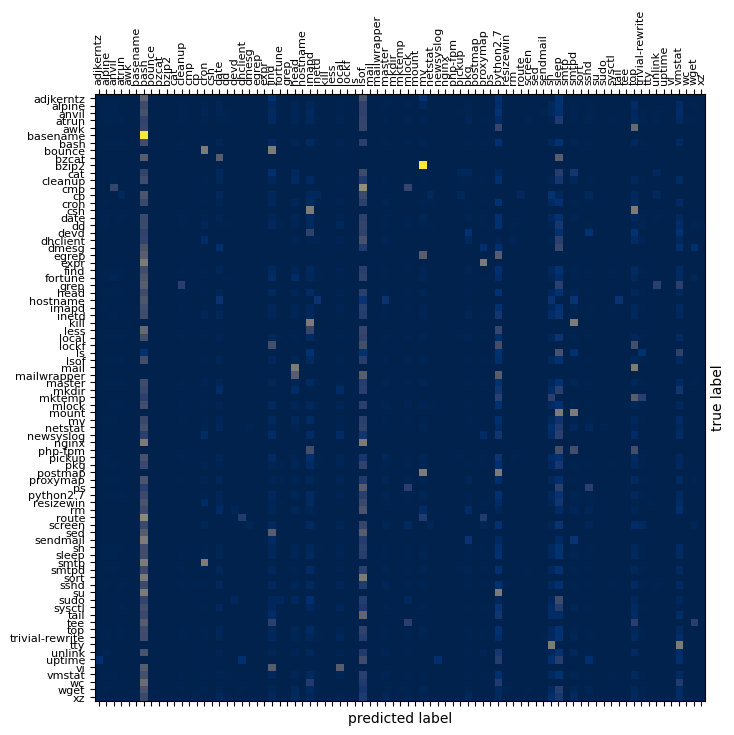

In [83]:
# print confusion matrix
# labels explicitly set, because current model may not predict all labels
conf_matrix = confusion_matrix(y_true, y_pred, labels=range(labels_cardinality), normalize='true')

# transform to percentage
# conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# replace all NaN values with 0
conf_matrix = np.nan_to_num(conf_matrix)

fig, ax = plt.subplots(figsize=(20*cm, 20*cm))

ax.matshow(conf_matrix, cmap='cividis', aspect='auto')

# Set class names on axes
ax.set_xticks(range(len(distinct_labels)))
ax.set_yticks(range(len(distinct_labels)))
ax.set_xticklabels(distinct_labels, rotation=90, fontsize=8)
ax.set_yticklabels(distinct_labels, fontsize=8)

# set axis labels "predicted" and "actual"
ax.set_xlabel('predicted label')
ax.set_ylabel('true label')
# y axis label right side
ax.yaxis.set_label_position('right')

# set figsize
plt.show()